# Using quadratic approximation and MCMC for regression of !Kung adults' height on their weight

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

In [2]:
ALPHA = 0.11

Data

In [3]:
dat = pd.read_csv('Data/Howell1.csv', sep=';')
dat_adults = dat[dat['age'] >= 18].sort_values('weight').reset_index(drop=True) # We are interested in adult's height

---

Fit the model and sample from the prior predictive.

In [4]:
with pm.Model() as ModelHeightWeight:
    alpha    = pm.Normal('alpha', mu=170, sigma=10)
    beta     = pm.Lognormal('beta', mu=0, sigma=0.1)
    sigma    = pm.Uniform('sigma', lower=0, upper=33)
    mu       = pm.Deterministic('mu', alpha + beta*(dat_adults['weight']-dat_adults['weight'].mean()))
    height   = pm.Normal('height', mu=mu, sigma=sigma, observed=dat_adults['height'])

    TraceModelHeightWeight = pm.sample_prior_predictive()   

Sampling: [alpha, beta, height, sigma]


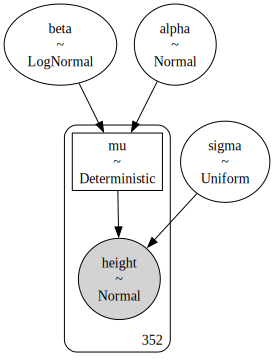

In [5]:
pm.model_to_graphviz(ModelHeightWeight)

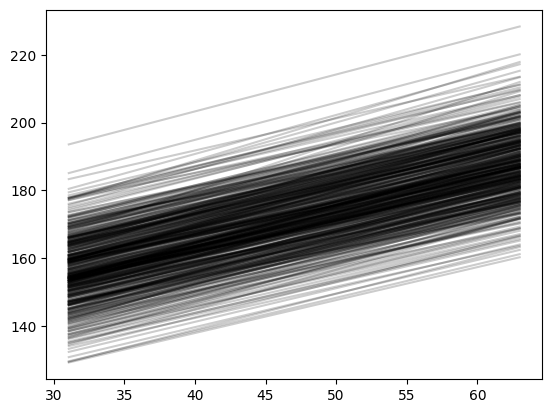

In [6]:
x_min, x_max = dat_adults['weight'].min(), dat_adults['weight'].max()
x = np.linspace(x_min-dat_adults['weight'].mean(), x_max-dat_adults['weight'].mean())

PriorAlpha = TraceModelHeightWeight.prior.alpha.values[0]
PriorBeta = TraceModelHeightWeight.prior.beta.values[0]

for a, b in zip(PriorAlpha, PriorBeta):
    y = a + b*x

    plt.plot(x+dat_adults['weight'].mean(), y, c='k', alpha=0.2)

Sample from the posterior

In [7]:
with ModelHeightWeight:
    TraceModelHeightWeight.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([[<Axes: >, None],
       [<Axes: xlabel='alpha', ylabel='beta'>, <Axes: >]], dtype=object)

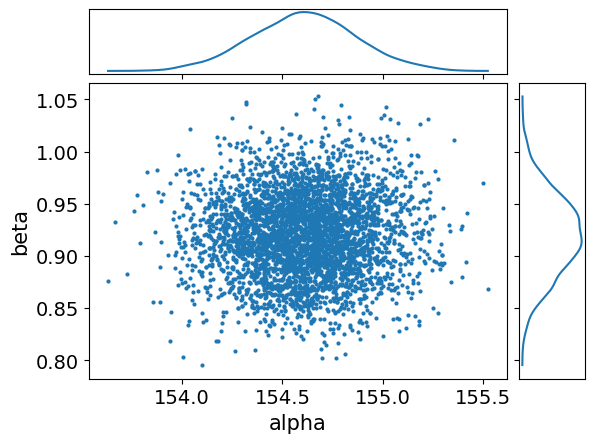

In [8]:
az.plot_pair(TraceModelHeightWeight, var_names=['alpha', 'beta'], marginals=True)

array([[<Axes: >, None],
       [<Axes: xlabel='alpha', ylabel='beta'>, <Axes: >]], dtype=object)

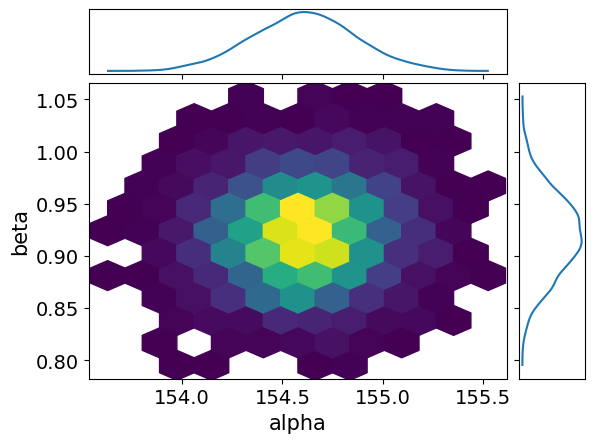

In [9]:
az.plot_pair(TraceModelHeightWeight, var_names=['alpha', 'beta'], kind="hexbin", marginals=True)

Posterior interval of $1-\alpha$ of probability.

In [10]:
az.summary(TraceModelHeightWeight, hdi_prob=1-ALPHA, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,154.607,0.263,154.191,155.035
beta,0.920,0.039,0.858,0.981
sigma,5.106,0.197,4.800,5.417
mu[0],142.531,0.571,141.677,143.477
mu[1],146.600,0.425,145.880,147.217
...,...,...,...,...
mu[347],165.249,0.531,164.429,166.096
mu[348],165.249,0.531,164.429,166.096
mu[349],170.074,0.717,168.971,171.225
mu[350],160.371,0.366,159.772,160.924


Sample from the predictive posterior

In [11]:
with ModelHeightWeight:
    TraceModelHeightWeight.extend(pm.sample_posterior_predictive(TraceModelHeightWeight))

Sampling: [height]


Plot the posterior predictive

<Axes: xlabel='height / height'>

/usr/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


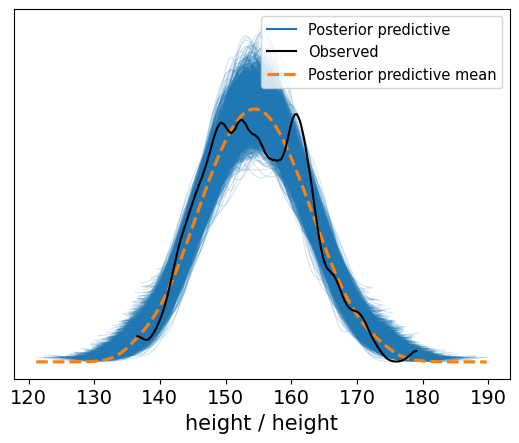

In [12]:
az.plot_ppc(TraceModelHeightWeight)

Plot the regression function with confidence and prediction intervals

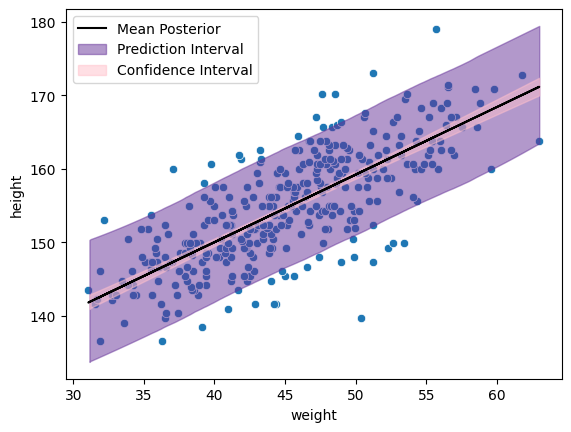

In [13]:
sns.scatterplot(x=dat_adults['weight'], y=dat_adults['height'])

plt.plot(
    dat_adults['weight']
    , TraceModelHeightWeight.posterior.mu.mean(('chain', 'draw'))
    , label="Mean Posterior"
    , color='k'
)

az.plot_hdi(
    dat_adults['weight']
    , TraceModelHeightWeight.posterior_predictive.height
    , hdi_prob=1-ALPHA
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Prediction Interval"}
)

az.plot_hdi(
    dat_adults['weight']
    , TraceModelHeightWeight.posterior.mu
    , hdi_prob=1-ALPHA
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':"Confidence Interval"}
)

plt.legend()